## Notebook 4 : Trends and forecasts of property values 

## 1 - Introduction ##

Overview of the notebook’s objective and the data used.


this notebook will help identifying the past trends and foresee the evolution of the property values. We will base this analysis on historical data. Retrospective analysis : How did the prices evolve throughout time ? Can we target global  and seasonal trends ? What would be the prices in 3, 5 or 10 years ? Those insights can be more robust by linking them to geographical comparisons.

Nous allons nous poser différentes questions pour mieux saisir le contexte :
- Comment les valeurs foncières ont-elles évolué de 2019 à 2024 ?
- Quelle régions ou types de biens ont montré une croissance ou un déclin ?
- Peut-on prédire les tendances futures des valeurs foncières ?


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [2]:
# Read in the data
df_tf = pd.read_csv('df_complete.csv', low_memory=False)

In [3]:
df_clean = df_tf[
    (df_tf['Valeur fonciere'] > 1000) & 
    (
        (df_tf['Surface reelle bati'] > 0) | (df_tf['Nombre pieces principales'] > 0) | (df_tf['Surface terrain']>10) &
        (df_tf['Type local']!='0')
    )
]
drop_columns=['Code commune', 'Code type local','Nombre de lots']
df_clean=df_clean.drop(columns=drop_columns, errors='ignore')



In [4]:
#### CONVERTS TO THE RIGHT TYPE ####
category_convert = ['Nature mutation', 'Code postal', 'Commune', 'Code departement', 'Type local']
df_clean[category_convert] = df_clean[category_convert].astype('category')

df_clean['Date mutation'] = pd.to_datetime(df_clean['Date mutation'], errors = 'coerce')
df_clean['Date mutation'] = df_clean['Date mutation'].interpolate(method='linear')

df_clean['Valeur fonciere']=df_clean['Valeur fonciere'].replace({'\xa0':'',',':'.'}, regex=True)
df_clean['Valeur fonciere']=pd.to_numeric(df_clean['Valeur fonciere'], errors='coerce')
df_clean['Mois'] = df_clean['Date mutation'].dt.month
df_clean['annee'] = df_clean['Date mutation'].dt.year
df_clean['Jour'] = df_clean['Date mutation'].dt.day

df_clean.info()
#print(df_clean[['Date mutation', 'Mois', 'Annee']].head())

<class 'pandas.core.frame.DataFrame'>
Index: 7902997 entries, 0 to 17810873
Data columns (total 14 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   Date mutation              datetime64[ns]
 1   Nature mutation            category      
 2   Valeur fonciere            float64       
 3   Voie                       object        
 4   Code postal                category      
 5   Commune                    category      
 6   Code departement           category      
 7   Type local                 category      
 8   Surface reelle bati        float64       
 9   Nombre pieces principales  float64       
 10  Surface terrain            float64       
 11  annee                      int32         
 12  Mois                       int32         
 13  Jour                       int32         
dtypes: category(5), datetime64[ns](1), float64(4), int32(3), object(1)
memory usage: 566.7+ MB


In [5]:
missing_values = df_clean.isnull().sum()
missing_values

Date mutation                0
Nature mutation              0
Valeur fonciere              0
Voie                         0
Code postal                  0
Commune                      0
Code departement             0
Type local                   0
Surface reelle bati          0
Nombre pieces principales    0
Surface terrain              0
annee                        0
Mois                         0
Jour                         0
dtype: int64

In [6]:
#### CHECK DUPLICATES ####
df_clean.drop_duplicates(keep='last', inplace=True)
df_clean = df_clean.sort_values('Date mutation').drop_duplicates(subset=['Valeur fonciere', 'Code postal', 'Commune', 'Nature mutation', 'annee'], keep='last')

# df_clean.duplicated().sum()

Lors du traitement des doublons dans la base DVF, il est très fréquent de rencontrer des doublons partiels, c'est-à-dire qu'ils ne sont pas complètement des copies exactes d'une ligne, mais représentent très certainement le même bien. 
Il n'y a que de légères variations dans certaines colonnes.

Les doublons partiels partagent souvent des valeurs communes pour les colonnes Valeur foncière, Code postal, Commune, Nature de mutation et Année. Les valeurs diffèrent parfois sur le Type de local, la Surface réelle batie, la Surface terrain ou le mois. 

Il est donc en réalité, plus complexe de manipuler et rejeter les doublons. D'une part on supprime les doublons exacts en gardant la dernière occurence, d'autre part on supprime les doublons partiels avec un subset.

En contrepartie, certaines lignes pourraient être supprimées, mais il était important de faire un compromis pour garantir une base de données plus cohérente et éviter la surchage des doublons. 

## 2 - Methodology ##

Explanation of the analysis methods and visualizations.

Data Exploration:
- Analyze the evolution of property values over time (by year).
- Identify significant periods of increase or decrease in prices.

In [23]:
df_clean[['Valeur fonciere', 'Surface reelle bati', 'Surface terrain']].describe()

,Valeur fonciere,Surface reelle bati,Surface terrain
count,4.218283e+06,4.218283e+06,4.218283e+06
mean,3.145719e+05,1.030868e+02,5.077559e+02
std,7.318489e+06,6.213762e+02,3.223688e+03
min,1.001000e+03,0.000000e+00,0.000000e+00
25%,1.110000e+05,4.400000e+01,0.000000e+00
50%,1.860000e+05,7.400000e+01,1.770000e+02
75%,3.015000e+05,1.020000e+02,5.790000e+02
max,1.415000e+10,2.650000e+05,3.760000e+06


In [8]:
high_values = df_clean[df_clean['Valeur fonciere'] > 1e6]
high_value_properties_sorted = high_values.sort_values('Valeur fonciere', ascending=False)

### Outliers ###

In [9]:
Q1 = df_clean['Valeur fonciere'].quantile(0.25)
Q3 = df_clean['Valeur fonciere'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#### Stock des valeurs outliers ####

D'autre part, nous créeons un Data Frame qui exclut les outliers, un autre Data Frame qui inclut les outliers seulement.

In [10]:
outliers = df_clean[(df_clean['Valeur fonciere'] < lower_bound) | 
                    (df_clean['Valeur fonciere'] > upper_bound)]
non_outliers = df_clean[(df_clean['Valeur fonciere'] >= lower_bound) & (df_clean['Valeur fonciere'] <= upper_bound)]

outliers.groupby(['annee', 'Type local'], observed=False)['Valeur fonciere'].agg(['count', 'mean', 'std'])

#### METRICS COMPARISON ####
# All
mean_all = df_clean['Valeur fonciere'].mean()
median_all = df_clean['Valeur fonciere'].median()

# Non-outliers
mean_non_outliers = non_outliers['Valeur fonciere'].mean()
median_non_outliers = non_outliers['Valeur fonciere'].median()

# Outliers
mean_outliers = outliers['Valeur fonciere'].mean()
median_outliers = outliers['Valeur fonciere'].median()

print("General mean :", mean_all)
print("General median :", median_all)
print("\nNon-outliers mean :", mean_non_outliers)
print("Non-outliers median :", median_non_outliers)
print("\nOutliers mean :", mean_outliers)
print("Outliers median :", median_outliers)

General mean : 314571.8959139558
General median : 186000.0

Non-outliers mean : 199410.04690305435
Non-outliers median : 175000.0

Outliers mean : 1832406.0027162067
Outliers median : 837600.0


### 1. Comment les valeurs foncières et le volume des transactions ont-ils évolué de 2019 à 2024 ? ###

#### 1.1 Analyse du volume des transactions ####

En chiffre, voici l'évolution du nombre de transactions réalisées de 2019 à 2024. On constate donc une augmentation et un pic du volume de transactions en 2022, et une baisse les années suivantes.

In [11]:
# Statistiques descriptives des colonnes temporelles
df_clean[['Mois', 'annee', 'Jour']].describe()
df_clean['Annee-Mois'] = df_clean['Date mutation'].dt.to_period('M')

# Nombre d'observations par mois et par année pour observer les tendances
observations_par_mois = df_clean['Annee-Mois'].value_counts().sort_index()
observations_par_annee = df_clean['annee'].value_counts().sort_index()

#print(observations_par_mois)
print(observations_par_annee)

annee
2019    492574
2020    817424
2021    950031
2022    909607
2023    728922
2024    319725
Name: count, dtype: int64


Le graphique ci-dessous représente l'évolution par mois et année des mutations immobilières de 2019 à 2024, par types de biens : appartements, maisons, dépendances et locaux industriels, commerciaux ou assimilés. Il permet de mettre en évidence des tendances saisonnières, des différences entre les catégories de biens, et d'identifier l’impact d’événements externes sur le volume global des transactions.

In [12]:
mutations_analyse=df_clean.copy()
mutations_analyse['Date mutation'] = pd.to_datetime(mutations_analyse['Date mutation'])
mutations_analyse['Annee'] = mutations_analyse['Date mutation'].dt.year
mutations_analyse['Annee-Mois'] = mutations_analyse['Date mutation'].dt.to_period('M').astype(str)

def plot_interactive(annee_range, type_bien=None):
    filtered_data = mutations_analyse[
        (mutations_analyse['Annee'] >= annee_range[0]) & 
        (mutations_analyse['Annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )

    plt.figure(figsize=(20, 6))
    sns.lineplot(
        data=sequences,
        x='Annee-Mois', y='count',
        hue='Type local', marker='o', palette='Set2'
    )
    plt.title('Évolution des transactions par Mois et Année')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Nombre de Transactions')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title='Type de Bien')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=[None] + list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type de Bien :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=False, description="Afficher Moyenne")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, type_bien=None)>

##### Le graphique comporte : #####
- En abscisses les mois et années de janvier 2019 à décembre 2024 pour illustrer une progression temporelle continue. Il est toutefois possible de modifier la plage de la période à observer.
- En ordonnées le nombre de transactions immobilières réalisées chaque mois.
- Différentes courbes, chacune représentant un type de local.

Nous observons un pattern saisonnier en termes de volume des transactions, quelle que soit la catégorie du bien. 
On peut identifier une augmentation régulière des transactions en début d'années, notamment pour les années 2020 à 2023. Cette augmentation intervient souvent vers janvier-février. Par la suite, le volume atteint un pic, généralement lors de la période estivale, c'est-à-dire autour de juin-juillet. Enfin, une baisse progressive a lieu en fin d'année, à partir de septembre.

On peut noter que les maisons et appartements ont une forte demande car ils répondent aux besoins essentiels d'habitation, tandis que les locaux industriels ont un public restreint et répondent à des besoins spécifiques. Ceci explique son marché moins dynamique. Cette demande croissante pour des logements individuels peut s'expliquer dans un contexte post-Covid où le télétravail a rendu les besoins d'espaces et de confort plus importants, également par le type d'acheteurs (les familles).

Nous allons examiner comment les moyennes et les médianes des valeurs foncières ont changé annuellement et mensuellement pendant cette période.

#### 1.1 Évolution annuelle et mensuelle des valeurs foncières ####

Cette première analyse nous permettra d'examiner l'évolution des valeurs foncières annuelles en termes de moyenne et de médiane. Il s'agit de comprendre les tendances générales et l'évolution du marché immobilier dans cette période.

Nous avons ci-dessous plusieurs graphiques qui tracent l'evolution de la médiane et la moyenne des valeurs foncières de 2019 à 2024. La séparation ou l'inclusion des outliers est importante pour comprendre la tendance réelle des valeurs foncières.

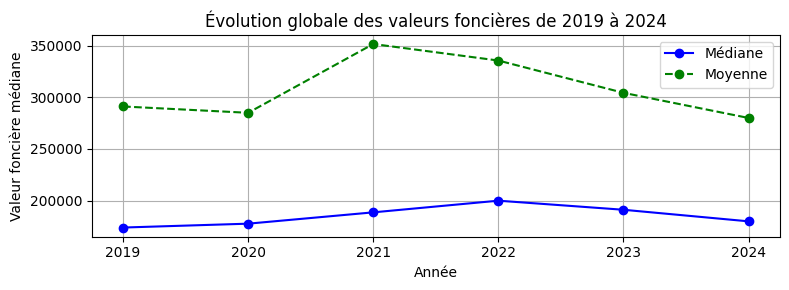

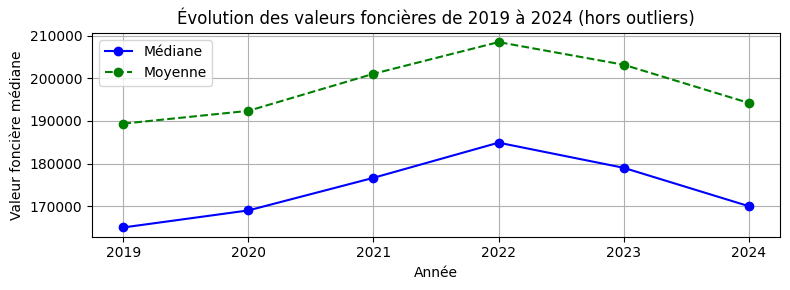

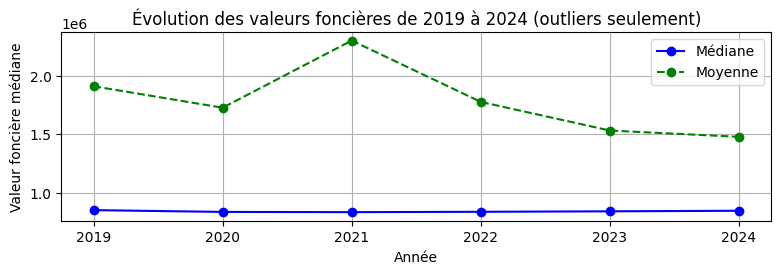

In [13]:
# Calcul de la médiane et de la moyenne par année
#outliers incllus
median_peryear = df_clean.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_peryear = df_clean.groupby('annee')['Valeur fonciere'].mean().reset_index()
def plot_evolution_all():
    plt.figure(figsize=(8, 3))
    plt.plot(median_peryear['annee'], median_peryear['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_peryear['annee'], mean_peryear['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Évolution globale des valeurs foncières de 2019 à 2024')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière médiane')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_evolution_all()

#sans outliers
median_nonoutliers=non_outliers.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_nonoutliers=non_outliers.groupby('annee')['Valeur fonciere'].mean().reset_index()

def plot_evolution_nonoutliers():
    plt.figure(figsize=(8, 3))
    plt.plot(median_nonoutliers['annee'], median_nonoutliers['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_nonoutliers['annee'], mean_nonoutliers['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Évolution des valeurs foncières de 2019 à 2024 (hors outliers)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière médiane')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_evolution_nonoutliers()

median_outliers=outliers.groupby('annee')['Valeur fonciere'].median().reset_index()
mean_outliers=outliers.groupby('annee')['Valeur fonciere'].mean().reset_index()

#seulement les outliers
def plot_evolution_outliers():
    plt.figure(figsize=(8, 3))
    plt.plot(median_outliers['annee'], median_outliers['Valeur fonciere'], marker='o', label='Médiane', color='blue')
    plt.plot(mean_outliers['annee'], mean_outliers['Valeur fonciere'], marker='o', label='Moyenne', color='green', linestyle='--')

    plt.title('Évolution des valeurs foncières de 2019 à 2024 (outliers seulement)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière médiane')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_evolution_outliers()


La médiane est la valeur centrale dans une distribution. 50% des valeurs sont en dessous et 50% sont au-dessus. Cela la rend moins sensibles aux outliers (valeurs extrêmes). En revanche, la moyenne est plus influencée par les valeurs extrêmes ou abberantes. 

Ce que nous pouvons observer de ces trois graphiques, est que les outliers jouent un rôle déterminant dans la moyenne globale (graphique 1), mais en les isolant, on obtient un résultat plus clair des tendances pour les valeurs centrales (graphique 2). En effet, La médiane et la moyenne sont proches avec une progression similaire. Dans le graphique 3, les valeurs sont très élevées, ce qui explique pourquoi la moyenne du graphique global était influencée. 

On remarquera que dans le graphique sans outliers, le pic se situe en 2022, alors que pour les graphiques 1 et 3, il apparaît en 2021.

Pour la suite de l'analyse, nous allons principalement se baser sur les non-outliers, pour établir des conclusions générales et observer les tendances du marché foncier standard. Il est tout de même intéressant de comprendre les dynamiques liées aux valeurs extrêmes et d'où elles viennent.

##### Statistiques #####

L'interprétation des statistiques des prix fonciers permet d'obtenir des insights sur l'évolution du marché de l'immobilier. Ci-dessous est affiché un tableau présentant la moyenne (mean), la médiane (median) et l'écart-type (std) pour chaque année étudiée (sans outliers).



In [14]:
annual_stats = non_outliers.groupby('annee')['Valeur fonciere'].agg(['mean', 'median', 'std']).reset_index()
annual_stats


,annee,mean,median,std
0,2019,189365.531240,165000.0,119529.815620
1,2020,192369.444734,169000.0,121188.751950
2,2021,201065.238020,176650.0,125465.137842
3,2022,208503.690000,184900.0,127639.138456
4,2023,203194.626697,179000.0,126929.749798
5,2024,194225.930634,170000.0,123672.239267


#### Zoom sur les prix moyens des transactions foncières par année (hors outliers) ####

- 2019 : 189 366 €
- 2020 : 192 369 € (+ 3 003 € soit +1.59%)
- 2021 : 201 065 € (+ 8 696 € soit +4.52%)
- 2022 : 208 504 € (+ 7 439 € soit +3.70%)
- 2023 : 203 195 € (- 5 309 € soit -2.55%)
- 2024 : 194 226 € (- 8 969 € soit -4.41%)

En 2021, on observe une hausse de 4.52% par rapport à 2020. Cette augmentation des prix peut être expliquée par plusieurs facteurs. Tout d'abord, la reprise économique post-Covid a pu entraîner un regain d'activité dans le secteur immobilier, d'autant que le taux d'intérêt atteint sa valeur la plus basse d'environ 1%, depuis juin 2020 (Source : L'Observatoire Crédit Logement, https://www.immobilier-danger.com/evolution-taux-immobilier.html). D'autre part, les changements dans les modes de vie dû au télétravail, a pu inciter les ménages à rechercher des espaces plus adaptés à leurs habitudes, comme les maisons en périphérie et en zone rurale.

En 2022, les prix continuent de croître avec une augmentation plus modérée de 3.70%. Outre l'aspect économique post-pandémie, et bien que le taux d'intérêt atteint jusqu'à près de 3% à la fin de l'année, la pénurie de biens immobiliers, notamment dans les régions attractives aurait pu contribuer à l'augmentation des prix. 

À partir de 2023 et surtout en 2024, les prix des biens connaissent une baisse. À la fin de l'année 2023, le taux atteint atteint plus de 4.24% avant de redescendre à 3.46% vers septembre 2024. Cette augmentation des taux par les banques centrales pour lutter contre l'inflation a rendu les emprunts plus chers, ce qui peut expliquer la baisse du prix immobilier.

Ci-dessous, nous montrons la différence entre la médiane et la moyenne chaque année. Nous pouvons observer clairement que les outliers ont un impact considérable dans la moyenne de la valeur foncière par année.

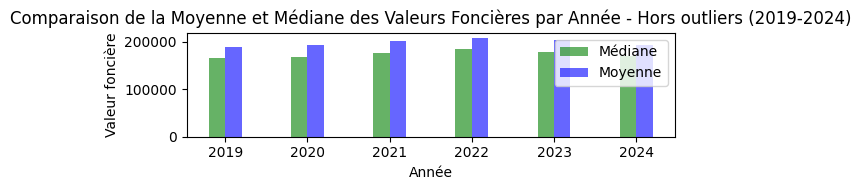

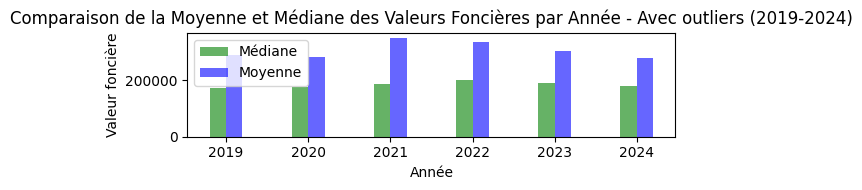

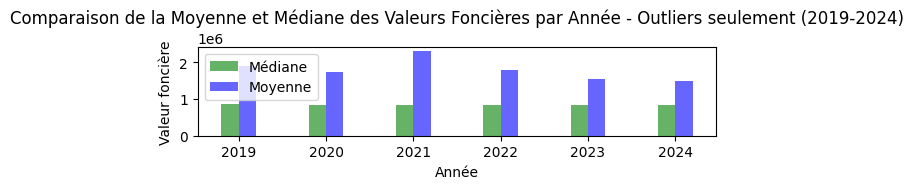

In [15]:
def plot_comparaison_moyenne_médiane():
    plt.figure(figsize=(6, 2))
    # Placer la médiane et la moyenne côte à côte
    x = mean_nonoutliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_nonoutliers['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_nonoutliers['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparaison de la Moyenne et Médiane des Valeurs Foncières par Année - Hors outliers (2019-2024)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane()

def plot_comparaison_moyenne_médiane_all():
    plt.figure(figsize=(6, 2))
    # Placer la médiane et la moyenne côte à côte
    x = mean_outliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_peryear['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_peryear['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparaison de la Moyenne et Médiane des Valeurs Foncières par Année - Avec outliers (2019-2024)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane_all()

def plot_comparaison_moyenne_médiane_outliers():
    plt.figure(figsize=(6, 2))
    # Placer la médiane et la moyenne côte à côte
    x = mean_outliers['annee']
    offset = 0.1 
    plt.bar(x - offset, median_outliers['Valeur fonciere'], width=offset * 2, label='Médiane', color='green', alpha=0.6)
    plt.bar(x + offset, mean_outliers['Valeur fonciere'], width=offset * 2, label='Moyenne', color='blue', alpha=0.6)
    plt.title('Comparaison de la Moyenne et Médiane des Valeurs Foncières par Année - Outliers seulement (2019-2024)')
    plt.xlabel('Année')
    plt.ylabel('Valeur foncière')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparaison_moyenne_médiane_outliers()


#### Zoom sur l'impact des outliers ####

L'écart-type permet de mesurer la dispersion des valeurs autour de la moyenne. Les outliers affectent directement cette mesure. En effet, l'écart-type est particulièrement sensible aux valeurs extrêmes. 


In [16]:
annual_stats_with_outliers=df_clean.groupby('annee')['Valeur fonciere'].agg(['std']).reset_index()
print('Écarts-type globaux (outliers inclus) : ')
annual_stats_with_outliers

Écarts-type globaux (outliers inclus) : 


,annee,std
0,2019,2.152591e+06
1,2020,1.944404e+06
2,2021,1.486710e+07
3,2022,2.983839e+06
4,2023,1.691317e+06
5,2024,1.100019e+06


In [17]:
annual_stats_outliers=outliers.groupby('annee')['Valeur fonciere'].agg(['std']).reset_index()
print('Écarts-type des outliers : ')
annual_stats_outliers

Écarts-type des outliers : 


,annee,std
0,2019,8.675388e+06
1,2020,7.753397e+06
2,2021,5.546531e+07
3,2022,1.035880e+07
4,2023,5.975738e+06
5,2024,4.041984e+06


Pour comprendre pourquoi l'écart-type est aussi élevé, il est important d'explorer les causes potentielles de cette dispersion.

Nous allons rapidement observer les outliers (valeurs extrêmes) pour chaque année : 

In [18]:
hvp=high_value_properties_sorted.groupby('annee')

def top_values_prop(annee):
    mostexp_by_year= hvp.get_group(annee).sort_values(by='Valeur fonciere', ascending=False).head(10)
    display(mostexp_by_year)

annee_widget=widgets.Dropdown(
    options=sorted(high_value_properties_sorted['annee'].unique()),description='Année : ',disabled=False
)
widgets.interactive(top_values_prop, annee=annee_widget)

interactive(children=(Dropdown(description='Année : ', options=(2019, 2020, 2021, 2022, 2023, 2024), value=201…

Le tableau ci-dessus affiche les 10 biens les plus chers chaque année. On remarque que les locaux sont généralement les biens les plus chers. Cela peut s'expliquer de différentes manières : 
- Les locaux tels que les bureaux, les centres commerciaux ont souvent une grande surface, et ils sont souvent dédiés aux entreprises de luxe ou de grandes marques. Ce sont des espaces qui demandent des aménagements précis.
- Il peut également s'agir des grands investisseurs comme REM (Real Estate Managers) qui recherchent ces types de biens.  

###### Exemples : En 2021, la vente situé à Arcueil (94), voie Nelson Mandela, correspond à un ensemble d'immeuble composant le siège social d'Orange et bénéficiant de travaux d'aménagement. (Source: CFNewsimmo https://www.cfnewsimmo.net/Annuaires-base-de-deals/Base-de-deals/Transaction-LES-PORTES-D-ARCUEIL-1-AVENUE-DU-PRESIDENT-NELSON-MANDELA-94110-ARCUEIL-lundi-12-juillet-2021) ######

###### Un autre cas semble être la transaction de Channel au 42 avenue Montaigne, en 2024, avec 600m2 de retail. D'après CFNewsimmo, le montant de la transaction est "légèrement supérieur à la barre des 250M€, ce qui correspond à la valeur foncière que nous avons dans le tableau. (https://www.cfnewsimmo.net/Les-Alertes-de-CFNEWS-IMMO/Chanel-ajoute-le-42-Montaigne-a-sa-collection-471870)
######

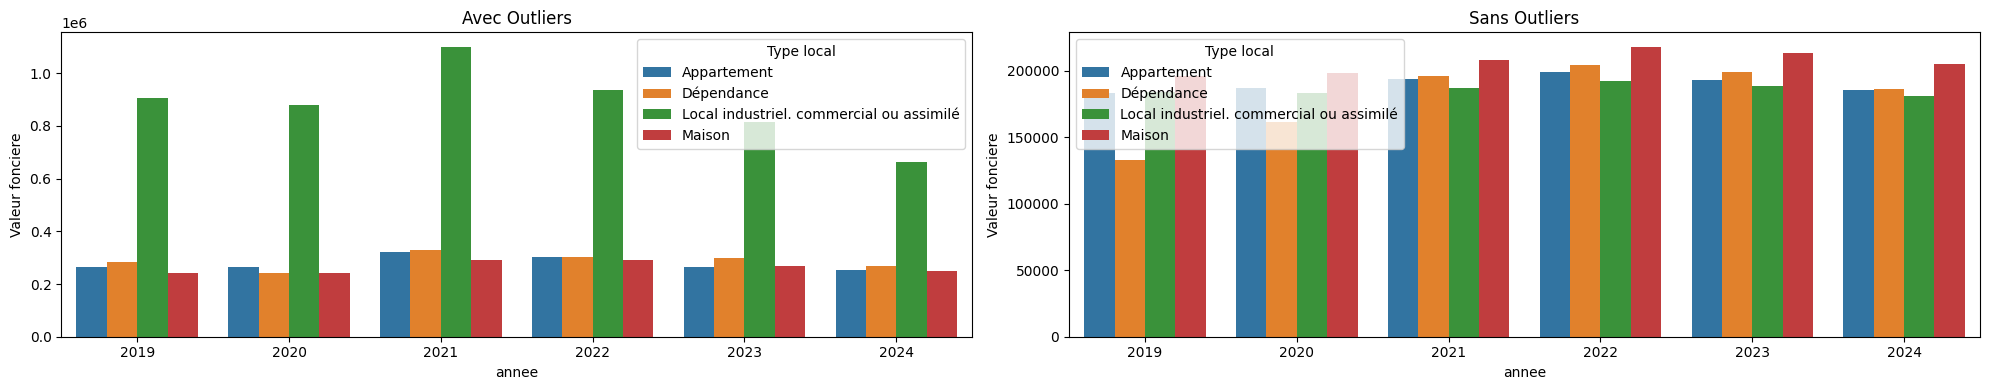

In [19]:
#comparer prix fonciers par type de biens avec/sans outliers
compare_all_type = df_clean.groupby(['annee', 'Type local'], observed=False).agg({'Valeur fonciere': 'mean'}).reset_index()
compare_nonoutliers_type = non_outliers.groupby(['annee', 'Type local'],observed=False).agg({'Valeur fonciere': 'mean'}).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.barplot(x='annee', y='Valeur fonciere', hue='Type local', data=compare_all_type, ax=ax[0])
ax[0].set_title('Avec Outliers')

sns.barplot(x='annee', y='Valeur fonciere', hue='Type local', data=compare_nonoutliers_type, ax=ax[1])
ax[1].set_title('Sans Outliers')

plt.tight_layout()
plt.show()

Les figures ci-dessus permettent de comparer les valeurs foncières par type de bien. On remarque clairement que les outliers représentent principalement les locaux, avec des valeurs dépassant les 600 000€. En 2021, ces biens atteignent même plus d'1M€. 

Sans les outliers, ce sont généralement les maisons qui affichent les valeurs les plus élevées, mais on constate globalement que les prix des biens se situent entre 150 000€ et 250 000€. Malgré la variation des transactions exceptionnelles, quelque soit le type de local, le prix des propriétés reste plutôt stable et se situe dans un intervalle bien plus modeste.

### 1.2 L'impact des événements et des politiques sur l'évolution des valeurs foncières ###

Observons les pics de hausse et de baisse sur le graphique suivant : 

In [20]:
mutations_analyse_wo_outliers=non_outliers.copy()
mutations_analyse_wo_outliers['Date mutation'] = pd.to_datetime(mutations_analyse_wo_outliers['Date mutation'])
mutations_analyse_wo_outliers['Annee'] = mutations_analyse_wo_outliers['Date mutation'].dt.year
mutations_analyse_wo_outliers['Annee-Mois'] = mutations_analyse_wo_outliers['Date mutation'].dt.to_period('M').astype(str)

def plot_interactive(annee_range, show_median=True, show_mean=True):
    # Filtrer les données par plage d'années et de mois
    filtered_data = mutations_analyse_wo_outliers[
        (mutations_analyse_wo_outliers['annee'] >= annee_range[0]) & 
        (mutations_analyse_wo_outliers['annee'] <= annee_range[1])
    ]    
    
    # Calcul des moyennes et des médianes pour la période et le type de bien filtrés
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )
    
    prix_medians = (
        filtered_data.groupby(['Annee-Mois'])['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    # Graphique de la moyenne et de la médiane
    plt.figure(figsize=(20, 6))
    
    if show_mean:
        sns.lineplot(
            data=prix_moyens,
            x='Annee-Mois', y='mean_price',
            label='Moyenne', marker='o', color='blue'
        )
        
    if show_median:
        sns.lineplot(
            data=prix_medians,
            x='Annee-Mois', y='median_price',
            label='Médiane', marker='o', color='orange'
        )
    
    plt.title('Évolution des Prix par Mois et Année - Hors outliers')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Prix (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='Statistiques')
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2019, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=True, description="Afficher Moyenne")
)

interactive(children=(IntRangeSlider(value=(2019, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, show_median=True, show_mean=True)>

In [21]:
def plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True):
    filtered_data = mutations_analyse_wo_outliers[
        (mutations_analyse_wo_outliers['Annee'] >= annee_range[0]) & 
        (mutations_analyse_wo_outliers['Annee'] <= annee_range[1])
    ]
    
    if type_bien: 
        filtered_data = filtered_data[filtered_data['Type local'] == type_bien]
    
    sequences = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)
        .size()
        .reset_index(name='count')
    )
    
    prix_moyens = (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .mean()
        .reset_index(name='mean_price')
    )

    prix_medians= (
        filtered_data.groupby(['Annee-Mois', 'Type local'],observed=False)['Valeur fonciere']
        .median()
        .reset_index(name='median_price')
    )

    plt.figure(figsize=(20, 6))
    if show_mean:
        sns.lineplot(
        data=prix_moyens,
        x='Annee-Mois', y='mean_price',
        hue='Type local', marker='o', palette='viridis'
    )
        
    if show_median:
        sns.lineplot(
        data=prix_medians,
        x='Annee-Mois', y='median_price',
        hue='Type local', marker='o', palette='Set2'
    )
    
    plt.title('Évolution des Prix par Mois et Année - Hors outliers - par type de bien')
    plt.xlabel('Temps (Année-Mois)')
    plt.ylabel('Prix (€)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

annee_widget = widgets.IntRangeSlider(
    value=[2021, 2023],
    min=2019, max=2024, step=1,
    description='Années :',
    continuous_update=False
)

type_bien_widget = widgets.Dropdown(
    options=list(mutations_analyse['Type local'].unique()),
    value=None,
    description="Type de Bien :"
)

interact(
    plot_interactive, 
    annee_range=annee_widget, 
    type_bien=type_bien_widget,
    show_median=widgets.Checkbox(value=True, description="Afficher Médiane"),
    show_mean=widgets.Checkbox(value=False, description="Afficher Moyenne")
)


interactive(children=(IntRangeSlider(value=(2021, 2023), continuous_update=False, description='Années :', max=…

<function __main__.plot_interactive(annee_range, type_bien='Maison', show_median=True, show_mean=True)>

#### 1.2.1 Chronologie - Analyses par rapport à la médiane. ####


##### 1. Fin 2019 - début 2020 #####

Avant la pandémie de Covid-10, les prix fonciers ont augmenté de 160 000€ à près de 175 000€ en un mois. À cette période, le taux d'intérêt de la BCE est très faible (0%). Les emprunts sont très attractifs, ce qui peut expliquer l'achat immobilier. 

##### 2. Décembre 2020 - Janvier 2021 #####

Les prix fonciers augmentent de 160 000€ à 180 000€. 
À partir de la pandémie, les critères des acheteurs ont changé, avec un besoin de plus d'espace, de confort, notamment dans des zones plus rurales pour correspondrre à une environnement de télétravail. Par ailleurs, le taux de la BCE reste toujours aussi bas, ce qui facilite l'accès au crédit. 
Cependant, l'inflation des matériaux de contruction se manifeste (https://www.insee.fr/fr/statistiques/5396320), ce qui contribue à la hausse des coûts pour les nouveaux projets de contruction, et indirectement à la hausse des prix fonciers.

#### 4. Novembre 2021 - Décembre 2021 ####



À la fin de l'année 2021, les prix augmentent une nouvelle, passant d'environ 168 000€ à 188 000€. D'après l'INSEE, le PIB progresse de 0.7% au quatrième trimestre 2021.  


Sources : 
- INSEE : Données sur l’inflation des matériaux de construction et l’évolution des coûts en 2021.
- Banque Centrale Européenne (BCE) : Politiques monétaires et impact sur l’emprunt immobilier. https://fr.tradingeconomics.com/euro-area/interest-rate 
- FMI : Analyses sur l’inflation et la reprise économique après la pandémie.
- Observatoire Crédit Logement : Rapport sur les taux d’intérêt et leur impact sur l’accès au crédit immobilier en 2022-2023.

## 3 - Results ##

Presentation of the analyses, visualizations, and findings.

Visualizations:
- Time series graphs showing property value trends over the years.
- Line charts comparing trends across different regions.

## 4 - Conlusion and recommandations ##

Summary of discoveries and investment advice.

Conclusions:
- Synthesize observed price trends over the past years.
- Identify external factors that could explain changes (e.g., economy, demographics, infrastructure).

Recommendations:
- Propose investment recommendations based on future price forecasts (e.g., investing in regions with predicted price growth).
- Risk management advice based on past and future property value trends.